## Скачивание данных для тренировки модели

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/Diploma\ ML-mid/train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/uncertain/1832.jpg  
  inflating: train/uncertain/1833.jpg  
  inflating: train/uncertain/1834.jpg  
  inflating: train/uncertain/1835.jpg  
  inflating: train/uncertain/1836.jpg  
  inflating: train/uncertain/1837.jpg  
  inflating: train/uncertain/1838.jpg  
  inflating: train/uncertain/1839.jpg  
  inflating: train/uncertain/184.jpg  
  inflating: train/uncertain/1840.jpg  
  inflating: train/uncertain/1841.jpg  
  inflating: train/uncertain/1842.jpg  
  inflating: train/uncertain/1843.jpg  
  inflating: train/uncertain/1844.jpg  
  inflating: train/uncertain/1845.jpg  
  inflating: train/uncertain/1846.jpg  
  inflating: train/uncertain/1847.jpg  
  inflating: train/uncertain/1848.jpg  
  inflating: train/uncertain/1849.jpg  
  inflating: train/uncertain/185.jpg  
  inflating: train/uncertain/1850.jpg  
  inflating: train/uncertain/1851.jpg  
  inflating: train/uncertain/1852.jpg  
  inflating: t

## Подготовка тренировочной и валидационной выборок

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 100
IMG_SHAPE  = 128 

dir = Path("train")

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2) 

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode="categorical",
                                                     subset = "training")

val_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='categorical',
                                                              subset = "validation")

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


## Импорт MobileNet V2 & transfer learning

In [ ]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False # замораживаем всю базовую модель
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

## Обучение модели

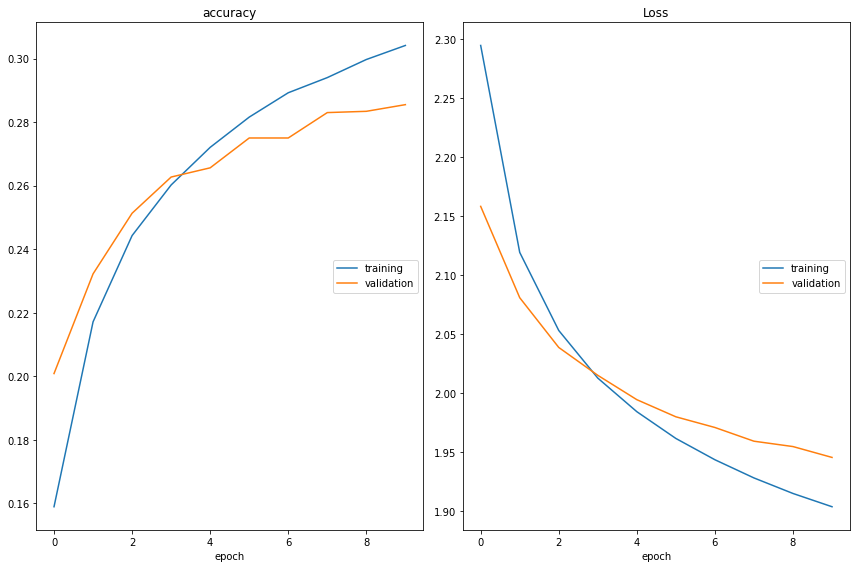

accuracy
	training         	 (min:    0.159, max:    0.304, cur:    0.304)
	validation       	 (min:    0.201, max:    0.286, cur:    0.286)
Loss
	training         	 (min:    1.904, max:    2.295, cur:    1.904)
	validation       	 (min:    1.945, max:    2.158, cur:    1.945)


In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

## Fine-tuning

In [ ]:
model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  154


In [ ]:
# fine_tune_at = 100
# все слои до -- заморозим
# for layer in base_model.layers[:fine_tune_at]:
  # layer.trainable =  False


model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5), # уменьшили скорость обучения
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 2,235,401
Non-trainable params: 34,112
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


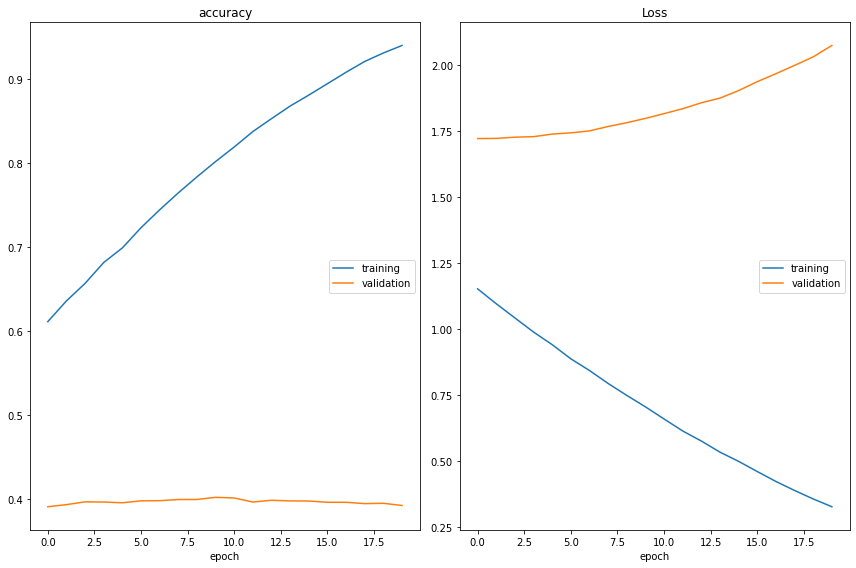

accuracy
	training         	 (min:    0.611, max:    0.940, cur:    0.940)
	validation       	 (min:    0.391, max:    0.403, cur:    0.393)
Loss
	training         	 (min:    0.326, max:    1.152, cur:    0.326)
	validation       	 (min:    1.722, max:    2.075, cur:    2.075)


In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

## Подготовка данных с аугментацией

### Аугментация данных и дальнейшее обучение модели такой же архитектуры:


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen = ImageDataGenerator() 


image_gen_aug = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   validation_split=0.2, 
                                   rotation_range=40,  
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode="nearest")

train_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode="categorical",
                                                     subset = "training")

val_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='categorical',
                                                              subset = "validation")

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


## Fine-tuning, обучение и сохранение модели

In [ ]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation="softmax")
])

model.trainable = True

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

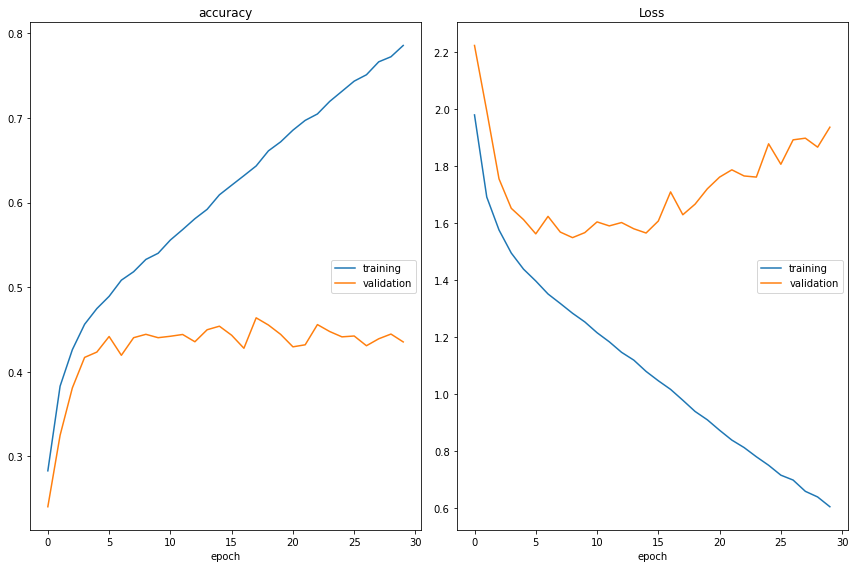

accuracy
	training         	 (min:    0.283, max:    0.786, cur:    0.786)
	validation       	 (min:    0.241, max:    0.464, cur:    0.435)
Loss
	training         	 (min:    0.605, max:    1.980, cur:    0.605)
	validation       	 (min:    1.549, max:    2.223, cur:    1.937)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [ ]:
model.save('/content/gdrive/MyDrive/models/Diploma ML-mid (default)/mobilenet_v2')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/Diploma ML-mid (default)/mobilenet_v2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/Diploma ML-mid (default)/mobilenet_v2/assets


## Проверка времени инференса

In [ ]:
import numpy as np
import cv2
from imageio import imread

data = np.empty((1, 128, 128, 3))

image = cv2.imread("/content/gdrive/MyDrive/data/Diploma ML-mid/test_kaggle/4914.jpg")
image = cv2.resize(image, (128, 128))
data[0] = image
data = preprocess_input(data)

In [ ]:
%%time

predictions = model.predict(data)

CPU times: user 40.2 ms, sys: 995 µs, total: 41.2 ms
Wall time: 43 ms


In [ ]:

np.argmax(predictions)

4